### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import json
from sqlite3 import dbapi2 as sq3
from pathlib import Path
from collections import OrderedDict

from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold
from surprise import Reader
from collections import defaultdict

from time import time
from IPython.display import clear_output

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras


from time import time
from IPython.display import clear_output
from collections import OrderedDict

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore')

### Loading Data

In [2]:
#Dataset Doc: https://www.yelp.com/dataset/documentation/main
#Data Paths
REVIEW_PATH = '/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json'      #Contains full review text data including the user_id that wrote the review and the business_id the review is written for.
CHECKIN_PATH = '/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json'    #Checkins on a business.
BUSINESS_PATH = '/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json'  #Contains business data including location data, attributes, and categories.
TIP_PATH = '/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json'            #Tips written by a user on a business. Tips are shorter than reviews and tend to convey quick suggestions.
USER_PATH = '/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json'          #User data including the user's friend mapping and all the metadata associated with the user.

# Functions to load data from json format
#ref: https://www.kaggle.com/hexianwang/yelp-data
def load_rows(file_path, nrows=None, only_return_count=False, verbose=True):
    """
    Returns dataframe from json file
    """
    tic = time()
    with open(file_path) as json_file:
        count = 0
        objs = []
        line = json_file.readline()
        while (nrows is None or count<nrows) and line:
            count += 1
            if not only_return_count:
                obj = json.loads(line)
                objs.append(obj)
            line = json_file.readline()
        toc = time()
        if verbose:
            print(file_path.split('/')[-1], 'loaded. Count =', count, ', Time =', round(toc-tic,2), 'secs.')
        
        if only_return_count:
            return count
        
        return pd.DataFrame(objs)
    
    
#data generator to load data in chunks
def load_rows_gen(file_path, nrows=1e6, verbose=True):
    """
    Returns data in chunks
    """
    with open(file_path) as json_file:
        line = json_file.readline()
        total = 0
        while line:
            count = 0
            objs = []
            tic = time()
            while count<nrows and line:
                count+=1
                obj = json.loads(line)
                objs.append(obj)
                line = json_file.readline()
                total += count
            toc = time()
            print('Loaded chunk of size:', count, ", Time =", round(toc-tic,2), 'secs.')
            yield pd.DataFrame(objs)

### Looking at data

In [3]:
user_df_head = load_rows(USER_PATH, 10)
user_df_head

yelp_academic_dataset_user.json loaded. Count = 10 , Time = 0.02 secs.


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0
5,q_QQ5kBBwlCcbL1s4NVK3g,Jane,1221,2005-03-14 20:26:35,14953,9940,11211,"2006,2007,2008,2009,2010,2011,2012,2013,2014","xBDpTUbai0DXrvxCe3X16Q, 7GPNBO496aecrjJfW6UWtg...",1357,...,163,191,361,147,1212,5696,2543,2543,815,323
6,cxuxXkcihfCbqt5Byrup8Q,Rob,12,2009-02-24 03:09:06,6,1,0,,"HDAQ74AEznP-YsMk1B14CA, 6A6-aIX7fg_zRy9MiE6YyQ...",1,...,0,0,0,0,0,1,0,0,0,0
7,E9kcWJdJUHuTKfQurPljwA,Mike,358,2008-12-11 22:11:56,399,102,143,,"y2GyxJF5VQWohxgw_GR7Jw, 0NRn4eY3JWN0IFqvOSa5gA...",23,...,7,2,0,0,8,6,12,12,5,0
8,lO1iq-f75hnPNZkTy3Zerg,Rachelle,40,2008-12-29 22:40:56,109,40,46,,"tOQDlz36rI__SOsbL-HCag, 83Xb0PPBwZiG2c_fLpZgAw...",7,...,0,0,3,0,3,4,5,5,3,1
9,AUi8MPWJ0mLkMfwbui27lg,John,109,2010-01-07 18:32:04,154,20,23,,"gy5fWeSv3Gamuq9Ox4MV4g, lMr3LWU6kPFLTmCpDkACxg...",4,...,0,0,0,0,1,6,3,3,0,0


In [4]:
review_df_head = load_rows(REVIEW_PATH, 10)
review_df_head

yelp_academic_dataset_review.json loaded. Count = 10 , Time = 0.0 secs.


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
6,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5.0,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18
7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16
8,ZKvDG2sBvHVdF5oBNUOpAQ,wSTuiTk-sKNdcFyprzZAjg,B5XSoSG3SfvQGtKEGQ1tSQ,3.0,1,1,0,This easter instead of going to Lopez Lake we ...,2016-03-30 22:46:33
9,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3.0,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06


In [5]:
business_df_head = load_rows(BUSINESS_PATH, 10)
business_df_head.head()

yelp_academic_dataset_business.json loaded. Count = 10 , Time = 0.01 secs.


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


### Create SQLite database
As data size is more than what our RAM can handle.

In [6]:
# Functions to work with db2api from sqlite3

PATHSTART = "."
def get_db(dbfile):
    #get connection to db
    sqlite_db = sq3.connect(Path(PATHSTART)/ dbfile)
    return sqlite_db

def init_db(dbfile, schema):
    #create db a/c to schema
    db = get_db(dbfile)
    
    #execute sql code
    c = db.cursor()
    c.executescript(schema)
    
    #make commit
    db.commit()
    return db

def make_query(sel):
    c = db.cursor().execute(sel)
    return c.fetchall()

from collections import OrderedDict
def make_frame(list_of_tuples, legend):
    framelist=[]
    for i, cname in enumerate(legend):
        framelist.append((cname,[e[i] for e in list_of_tuples]))
    return pd.DataFrame.from_dict(OrderedDict(framelist)) 

In [7]:
#Table Schema for tables in our SQLite database

users_schema = """
DROP TABLE IF EXISTS "users";

CREATE TABLE "users" (
    "user_id" INTEGER PRIMARY KEY NOT NULL,
    "name" VARCHAR,
    "review_count" INTEGER,
    "yelping_since" TIMESTAMP,
    "useful" INTEGER,
    "funny" INTEGER,
    "cool" INTEGER,
    "elite" VARCHAR,
    "friends" VARCHAR,
    "fans" INTEGER,
    "average_stars" FLOAT,
    "compliment_hot" INTEGER,
    "compliment_more" INTEGER, 
    "compliment_profile" INTEGER,
    "compliment_cute" INTEGER,
    "compliment_list" INTEGER,
    "compliment_note" INTEGER,
    "compliment_plain" INTEGER,
    "compliment_cool" INTEGER,
    "compliment_funny" INTEGER,
    "compliment_writer" INTEGER,
    "compliment_photos" INTEGER
);
"""
businesses_schema="""
DROP TABLE IF EXISTS "businesses";

CREATE TABLE "businesses" (
    "business_id" INTEGER PRIMARY KEY NOT NULL,
    "name" VARCHAR,
    "address" VARCHAR,
    "city" VARCHAR,
    "state" VARCHAR,
    "postal_code" VARCHAR,
    "latitude" FLOAT,
    "longitude" FLOAT,
    "stars" FLOAT,
    "review_count" INTEGER,
    "is_open" BOOLEAN,
    "categories" VARCHAR,
"""
reviews_schema = """
DROP TABLE IF EXISTS "reviews";

CREATE TABLE "reviews" (
    "review_id" VARCHAR PRIMARY KEY,
    "user_id" INTEGER,
    "business_id" INTEGER,
    "stars" FLOAT,
    "useful" INTEGER,
    "funny" INTEGER,
    "cool" INTEGER,
    "text"  VARCHAR,
    "date" TIMESTAMP,
    
    
    FOREIGN KEY (user_id) REFERENCES users(user_id),
    FOREIGN KEY (business_id) REFERENCES businesses(business_id)
);
"""
schema_close = ");"

In [8]:
users_schema

'\nDROP TABLE IF EXISTS "users";\n\nCREATE TABLE "users" (\n    "user_id" INTEGER PRIMARY KEY NOT NULL,\n    "name" VARCHAR,\n    "review_count" INTEGER,\n    "yelping_since" TIMESTAMP,\n    "useful" INTEGER,\n    "funny" INTEGER,\n    "cool" INTEGER,\n    "elite" VARCHAR,\n    "friends" VARCHAR,\n    "fans" INTEGER,\n    "average_stars" FLOAT,\n    "compliment_hot" INTEGER,\n    "compliment_more" INTEGER, \n    "compliment_profile" INTEGER,\n    "compliment_cute" INTEGER,\n    "compliment_list" INTEGER,\n    "compliment_note" INTEGER,\n    "compliment_plain" INTEGER,\n    "compliment_cool" INTEGER,\n    "compliment_funny" INTEGER,\n    "compliment_writer" INTEGER,\n    "compliment_photos" INTEGER\n);\n'

In [9]:
businesses_schema

'\nDROP TABLE IF EXISTS "businesses";\n\nCREATE TABLE "businesses" (\n    "business_id" INTEGER PRIMARY KEY NOT NULL,\n    "name" VARCHAR,\n    "address" VARCHAR,\n    "city" VARCHAR,\n    "state" VARCHAR,\n    "postal_code" VARCHAR,\n    "latitude" FLOAT,\n    "longitude" FLOAT,\n    "stars" FLOAT,\n    "review_count" INTEGER,\n    "is_open" BOOLEAN,\n    "categories" VARCHAR,\n'

In [10]:
reviews_schema

'\nDROP TABLE IF EXISTS "reviews";\n\nCREATE TABLE "reviews" (\n    "review_id" VARCHAR PRIMARY KEY,\n    "user_id" INTEGER,\n    "business_id" INTEGER,\n    "stars" FLOAT,\n    "useful" INTEGER,\n    "funny" INTEGER,\n    "cool" INTEGER,\n    "text"  VARCHAR,\n    "date" TIMESTAMP,\n    \n    \n    FOREIGN KEY (user_id) REFERENCES users(user_id),\n    FOREIGN KEY (business_id) REFERENCES businesses(business_id)\n);\n'

In [11]:
#Load data about all businesses
business_df = load_rows(BUSINESS_PATH)
business_df.head()

yelp_academic_dataset_business.json loaded. Count = 150346 , Time = 3.69 secs.


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [12]:
%%time

#Here we preprocess our businesses data
def preprocess_business_df(df):
    """
    Preprocess data from BUSINESS_PATH
    returns final DataFrame
    """
    #mask to only select businesses which are either Restaurant or serve Food
    mask = df.categories.str.contains('Restaurant', na=False) | df.categories.str.contains('Food', na=False)
    df = df[mask]
    #Changing business_id to numbers
    global businessid_to_idx
    businessid_to_idx = {b_id : idx for idx, b_id in enumerate(df.business_id.unique())}
    df.business_id = df.business_id.map(lambda x: businessid_to_idx[x])

    #TDT
    df.is_open = df.is_open.astype(bool)

    # Exploding attributes [MultiCategorization]
    attr = [col for col in df.attributes.explode().unique() if col is not None]
    lst_of_attr_dict = []
    for attr_dict in df.attributes:
        if not attr_dict:
            lst_of_attr_dict.append({})
            continue

        if 'BusinessParking' in attr_dict:
            if type(attr_dict['BusinessParking']) == str:
                attr_dict['BusinessParking'] = ('True' in attr_dict['BusinessParking'])

        lst_of_attr_dict.append(attr_dict)
    
    attr_df = pd.DataFrame(lst_of_attr_dict, columns=attr)
    for col in attr_df:
        #Handling missing
        #Strategy -> absence of attribute means restauratn doesn't have it
        #ex. If parking is null then restaurant doesn't have parking
        attr_df[col] = attr_df[col].fillna(False).astype(bool)
    
    df = pd.concat([df.reset_index().drop('index', axis=1), attr_df], axis=1)
    df.drop(['attributes'], axis=1, inplace=True)
    
    #Exploding hours ie. getting opening and closing time for various days
    lst_of_time = []
    for time_dict in df.hours:
        if not time_dict:
            lst_of_time.append({})
            continue
        lst_of_time.append(time_dict)
    time_df = pd.DataFrame(lst_of_time)
    df = pd.concat([df, time_df], axis=1).drop('hours', axis=1)
    
    return df

business_df = preprocess_business_df(business_df)
business_df.head()

CPU times: user 2.86 s, sys: 39.6 ms, total: 2.9 s
Wall time: 2.9 s


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,AgesAllowed,DietaryRestrictions,HairSpecializesIn,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,0,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,False,False,False,7:0-20:0,7:0-20:0,7:0-20:0,7:0-20:0,7:0-21:0,7:0-21:0,7:0-21:0
1,1,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,...,False,False,False,NaN,NaN,14:0-22:0,16:0-22:0,12:0-22:0,12:0-22:0,12:0-18:0
2,2,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,False,False,False,0:0-0:0,6:0-22:0,6:0-22:0,6:0-22:0,9:0-0:0,9:0-22:0,8:0-22:0
3,3,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,...,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,False,False,False,0:0-0:0,6:0-21:0,6:0-21:0,6:0-16:0,6:0-16:0,6:0-17:0,6:0-21:0


In [13]:
# Looking at overview of our data
business_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64629 entries, 0 to 64628
Data columns (total 58 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 64629 non-null  int64  
 1   name                        64629 non-null  object 
 2   address                     64629 non-null  object 
 3   city                        64629 non-null  object 
 4   state                       64629 non-null  object 
 5   postal_code                 64629 non-null  object 
 6   latitude                    64629 non-null  float64
 7   longitude                   64629 non-null  float64
 8   stars                       64629 non-null  float64
 9   review_count                64629 non-null  int64  
 10  is_open                     64629 non-null  bool   
 11  categories                  64629 non-null  object 
 12  RestaurantsDelivery         64629 non-null  bool   
 13  OutdoorSeating              646

In [14]:
# Completing Business Table Schema
for bool_col in business_df.columns[12:51]:
    businesses_schema += '    \"' + bool_col + '\"' + ' BOOLEAN,\n'
for day in business_df.columns[51:]:
    businesses_schema += '    \"' + day + '\"' + ' VARCHAR,\n'
    
businesses_schema = businesses_schema[:-2] + schema_close

In [15]:
businesses_schema

'\nDROP TABLE IF EXISTS "businesses";\n\nCREATE TABLE "businesses" (\n    "business_id" INTEGER PRIMARY KEY NOT NULL,\n    "name" VARCHAR,\n    "address" VARCHAR,\n    "city" VARCHAR,\n    "state" VARCHAR,\n    "postal_code" VARCHAR,\n    "latitude" FLOAT,\n    "longitude" FLOAT,\n    "stars" FLOAT,\n    "review_count" INTEGER,\n    "is_open" BOOLEAN,\n    "categories" VARCHAR,\n    "RestaurantsDelivery" BOOLEAN,\n    "OutdoorSeating" BOOLEAN,\n    "BusinessAcceptsCreditCards" BOOLEAN,\n    "BusinessParking" BOOLEAN,\n    "BikeParking" BOOLEAN,\n    "RestaurantsPriceRange2" BOOLEAN,\n    "RestaurantsTakeOut" BOOLEAN,\n    "ByAppointmentOnly" BOOLEAN,\n    "WiFi" BOOLEAN,\n    "Alcohol" BOOLEAN,\n    "Caters" BOOLEAN,\n    "WheelchairAccessible" BOOLEAN,\n    "GoodForKids" BOOLEAN,\n    "RestaurantsAttire" BOOLEAN,\n    "RestaurantsReservations" BOOLEAN,\n    "Ambience" BOOLEAN,\n    "CoatCheck" BOOLEAN,\n    "DogsAllowed" BOOLEAN,\n    "RestaurantsTableService" BOOLEAN,\n    "Restauran

In [16]:
%%time
#Create db
db = init_db("yelp_database.db", users_schema+businesses_schema+reviews_schema)

#business data to sql
business_df.to_sql('businesses', db, if_exists='append', index=False)

#release memory
del business_df

CPU times: user 3.12 s, sys: 34.4 ms, total: 3.15 s
Wall time: 3.26 s


In [17]:
#load data about users
user_df = load_rows(USER_PATH)
user_df.head()

yelp_academic_dataset_user.json loaded. Count = 1987897 , Time = 62.47 secs.


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0


In [18]:
%%time
#Preproccess user data
def preprocess_user_df(df):
    #Changing user id to something more suitable for our analysis
    global userid_to_idx
    userid_to_idx = {user : idx for idx, user in enumerate(df.user_id.unique())}
    df.user_id = df.user_id.map(lambda x: userid_to_idx[x])
    #Changing friends ids to new int ids
    df.friends = df.friends.map(lambda x : str([userid_to_idx[user] for user in x.split(',') if user in userid_to_idx]))
    #TDT to datetime
    df.yelping_since = pd.to_datetime(df.yelping_since)
    df.elite = df.elite.replace('', np.nan)
    return df

user_df = preprocess_user_df(user_df)

CPU times: user 45.4 s, sys: 6.14 ms, total: 45.4 s
Wall time: 45.4 s


In [19]:
user_df.head()

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,0,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,[1625],267,...,65,55,56,18,232,844,467,467,239,180
1,1,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",[399628],3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013",[],52,...,13,10,17,3,66,96,119,119,35,18
3,3,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011",[1605735],28,...,4,1,6,2,12,16,26,26,10,9
4,4,Karen,79,2007-01-05 19:40:59,29,15,7,NaN,[],1,...,1,0,0,0,1,1,0,0,0,0


In [20]:
%%time
#Sending user data to SQL db
user_df.to_sql('users', db, if_exists='append', index=False)
#Release memory
del user_df

CPU times: user 16.9 s, sys: 717 ms, total: 17.6 s
Wall time: 18.1 s


In [21]:
%%time
#Here we load data from reviews

#size of review.json overpowers RAM hence we'll process data in chunks and store it to table
for data in load_rows_gen(REVIEW_PATH):
    #transformations
    data.user_id = data.user_id.apply(lambda key : userid_to_idx[key] if key in userid_to_idx else np.nan)
    data.business_id = data.business_id.apply(lambda key : businessid_to_idx[key] if key in businessid_to_idx else np.nan)
    data.date = pd.to_datetime(data.date)
    data.dropna(inplace=True)
    #sending chunk to sql
    data.to_sql('reviews', db, if_exists='append', index=False)
#del data

Loaded chunk of size: 1000000 , Time = 14.77 secs.
Loaded chunk of size: 1000000 , Time = 14.57 secs.
Loaded chunk of size: 1000000 , Time = 14.7 secs.
Loaded chunk of size: 1000000 , Time = 15.05 secs.
Loaded chunk of size: 1000000 , Time = 15.32 secs.
Loaded chunk of size: 1000000 , Time = 14.64 secs.
Loaded chunk of size: 990280 , Time = 15.78 secs.
CPU times: user 3min 23s, sys: 55.4 s, total: 4min 18s
Wall time: 5min 15s


In [22]:
#Looking at last chunk
data.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,LEt_rcvZ9UsAhQCRGRBkVQ,55859.0,57066.0,4.0,1,1,0,Very good food here! Casual dining in the Don...,2017-05-12 23:58:29
2,K4gdzC3ut1SJAkHWR_YGQQ,913166.0,57082.0,1.0,0,0,0,"The bar 33 is nice but restaurant overrated, h...",2016-05-15 05:00:45
3,7hGVG9nUzhpiiSAniPDTbg,51384.0,52530.0,3.0,2,0,2,The place is located inside the new China Town...,2017-04-06 23:17:53
4,1z_2diaMLhSkc0z4L0BxnQ,415994.0,55602.0,2.0,3,0,0,Ordered Chicken Fried Rice. Rice was not fried...,2018-11-27 02:18:43
6,-pMqa4mXtbsT0VYePB5xHA,1489292.0,57703.0,5.0,1,0,0,The desserts and dinner are spectacular! Not ...,2019-04-28 02:50:57


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 715569 entries, 0 to 990279
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   review_id    715569 non-null  object        
 1   user_id      715569 non-null  float64       
 2   business_id  715569 non-null  float64       
 3   stars        715569 non-null  float64       
 4   useful       715569 non-null  int64         
 5   funny        715569 non-null  int64         
 6   cool         715569 non-null  int64         
 7   text         715569 non-null  object        
 8   date         715569 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(3), object(2)
memory usage: 54.6+ MB


In [24]:
#Release memory
del data

In [25]:
def make_query(sel):
    """Query database"""
    c = db.cursor().execute(sel)
    return c.fetchall()

def make_frame(list_of_tuples=None, legend=[], query=None):
    """
    Returns DataFrame from a query or result of query
    """
    framelist=[]
    if list_of_tuples is None:
        if query is None:
            print("Error: No query made")
            return
        list_of_tuples = make_query(query)
        
    for i, cname in enumerate(legend):
        framelist.append((cname,[e[i] for e in list_of_tuples]))
    return pd.DataFrame.from_dict(OrderedDict(framelist))

# Connect to database
db = sq3.connect('/kaggle/working/yelp_database.db')

In [26]:
# Looking at business table's columns and theirdtypes
make_query("PRAGMA table_info(businesses)")

[(0, 'business_id', 'INTEGER', 1, None, 1),
 (1, 'name', 'VARCHAR', 0, None, 0),
 (2, 'address', 'VARCHAR', 0, None, 0),
 (3, 'city', 'VARCHAR', 0, None, 0),
 (4, 'state', 'VARCHAR', 0, None, 0),
 (5, 'postal_code', 'VARCHAR', 0, None, 0),
 (6, 'latitude', 'FLOAT', 0, None, 0),
 (7, 'longitude', 'FLOAT', 0, None, 0),
 (8, 'stars', 'FLOAT', 0, None, 0),
 (9, 'review_count', 'INTEGER', 0, None, 0),
 (10, 'is_open', 'BOOLEAN', 0, None, 0),
 (11, 'categories', 'VARCHAR', 0, None, 0),
 (12, 'RestaurantsDelivery', 'BOOLEAN', 0, None, 0),
 (13, 'OutdoorSeating', 'BOOLEAN', 0, None, 0),
 (14, 'BusinessAcceptsCreditCards', 'BOOLEAN', 0, None, 0),
 (15, 'BusinessParking', 'BOOLEAN', 0, None, 0),
 (16, 'BikeParking', 'BOOLEAN', 0, None, 0),
 (17, 'RestaurantsPriceRange2', 'BOOLEAN', 0, None, 0),
 (18, 'RestaurantsTakeOut', 'BOOLEAN', 0, None, 0),
 (19, 'ByAppointmentOnly', 'BOOLEAN', 0, None, 0),
 (20, 'WiFi', 'BOOLEAN', 0, None, 0),
 (21, 'Alcohol', 'BOOLEAN', 0, None, 0),
 (22, 'Caters', 'BOOLE

In [27]:
#Getting dataframe from table
business_df_cols = list(zip(*make_query("PRAGMA table_info(businesses)")))[1]
business_df = make_frame(query='SELECT business_id,name,stars,review_count,is_open,categories,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,ByAppointmentOnly,WiFi,Alcohol,Caters,WheelchairAccessible ,GoodForKids,RestaurantsAttire,RestaurantsReservations ,Ambience,CoatCheck,DogsAllowed,RestaurantsTableService,RestaurantsGoodForGroups,HasTV,HappyHour,DriveThru,NoiseLevel,GoodForMeal,BusinessAcceptsBitcoin,Smoking,Music,GoodForDancing,BestNights,BYOB,Corkage,BYOBCorkage,AcceptsInsurance,RestaurantsCounterService,Open24Hours,AgesAllowed,DietaryRestrictions,HairSpecializesIn   FROM businesses', legend=['business_id','Restaurant_name','stars','review_count','is_open','categories','RestaurantsDelivery','OutdoorSeating','BusinessAcceptsCreditCards','BusinessParking','BikeParking','RestaurantsPriceRange2','RestaurantsTakeOut','ByAppointmentOnly','WiFi','Alcohol','Caters','WheelchairAccessible','GoodForKids','RestaurantsAttire','RestaurantsReservations','Ambience','CoatCheck','DogsAllowed','RestaurantsTableService','RestaurantsGoodForGroups','HasTV','HappyHour','DriveThru','NoiseLevel','GoodForMeal','BusinessAcceptsBitcoin','Smoking','Music','GoodForDancing','BestNights','BYOB','Corkage','BYOBCorkage','AcceptsInsurance','RestaurantsCounterService','Open24Hours','AgesAllowed','DietaryRestrictions','HairSpecializesIn'])
business_df.head()

,business_id,Restaurant_name,stars,review_count,is_open,categories,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BusinessParking,...,BestNights,BYOB,Corkage,BYOBCorkage,AcceptsInsurance,RestaurantsCounterService,Open24Hours,AgesAllowed,DietaryRestrictions,HairSpecializesIn
0,0,St Honore Pastries,4.0,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,Perkiomen Valley Brewery,4.5,13,1,"Brewpubs, Breweries, Food",0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,2,Sonic Drive-In,2.0,6,1,"Burgers, Fast Food, Sandwiches, Food, Ice Crea...",1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,3,Tsevi's Pub And Grill,3.0,19,0,"Pubs, Restaurants, Italian, Bars, American (Tr...",1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,4,Sonic Drive-In,1.5,10,1,"Ice Cream & Frozen Yogurt, Fast Food, Burgers,...",1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
business_df.shape

(64629, 45)

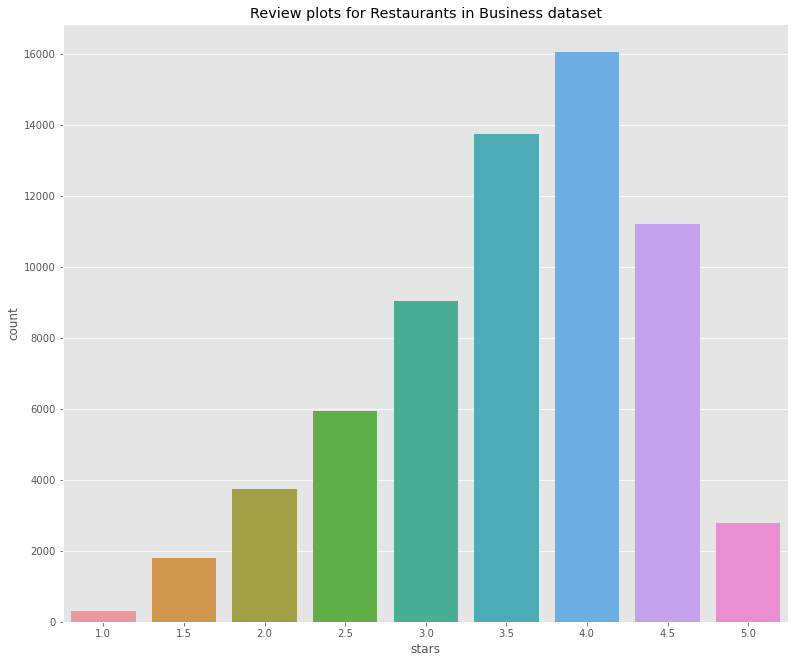

In [29]:
fig, ax = plt.subplots(figsize = (13,11))
sns.countplot(business_df['stars'], ax=ax)
plt.title('Review plots for Restaurants in Business dataset')
plt.show()

[Text(0.5, 0, 'Restaurant'), Text(0, 0.5, 'Review Count')]

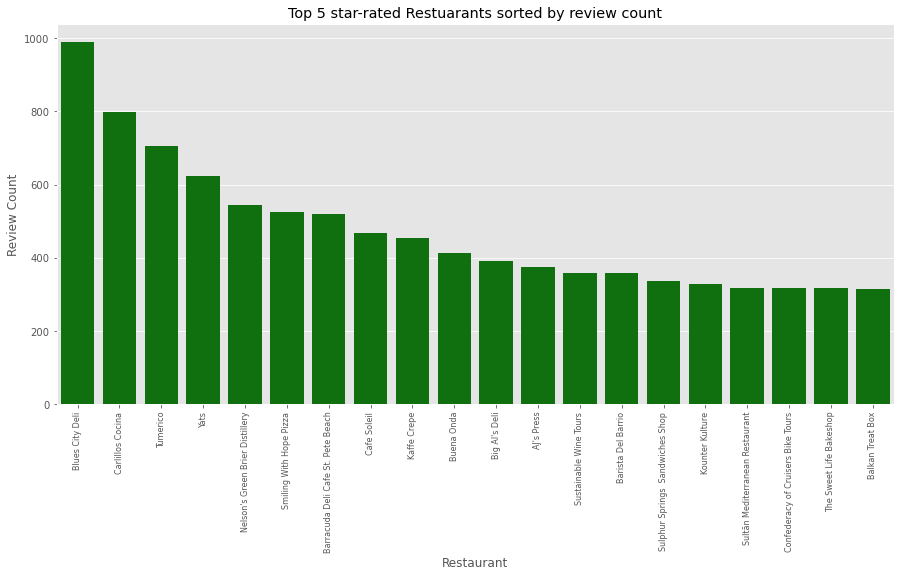

In [30]:
top_res = business_df[business_df["stars"]==5]
top_res = top_res.sort_values('review_count', ascending=False).head(20)

plt.figure(figsize=(15,7))
p = sns.barplot(x='Restaurant_name', y="review_count", data=top_res,color="g")
p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 8)
p.set_title("Top 5 star-rated Restuarants sorted by review count")
p.set(xlabel="Restaurant", ylabel="Review Count")

[Text(0.5, 0, 'Restaurant'), Text(0, 0.5, 'Review Count')]

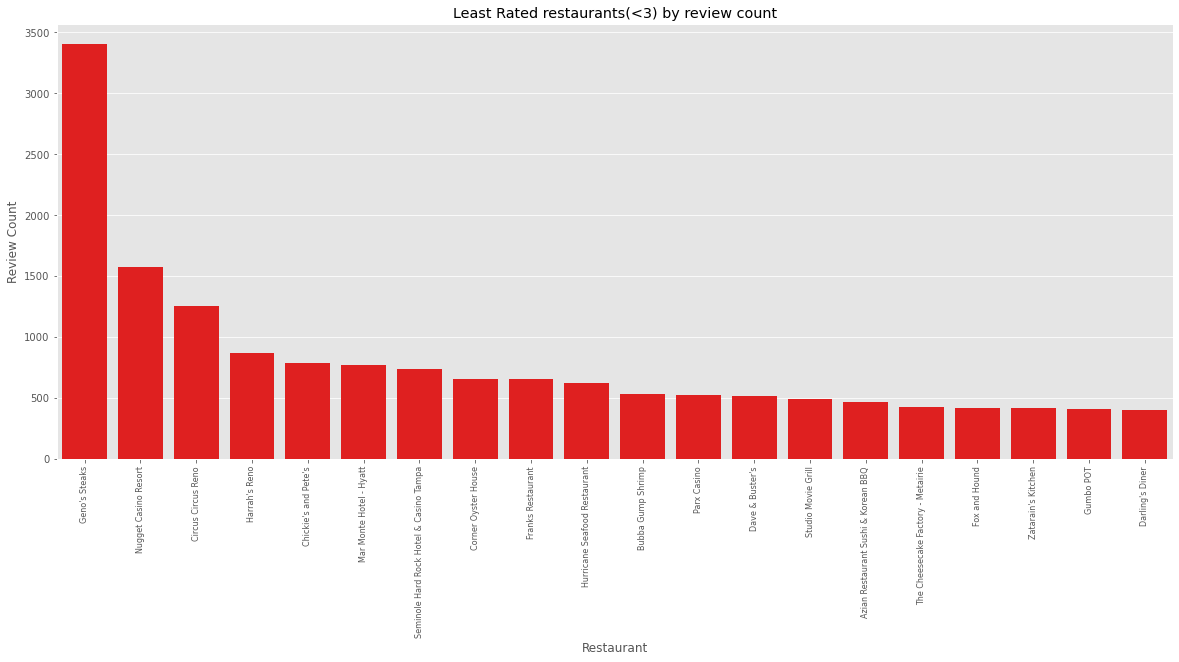

In [31]:
top_res = business_df[business_df["stars"]< 3]
top_res = top_res.sort_values('review_count', ascending=False).head(20)

plt.figure(figsize=(20,8))
p = sns.barplot(x='Restaurant_name', y="review_count", data=top_res,color="r")
p.set_xticklabels(p.get_xticklabels(), rotation = 90, fontsize = 8)
p.set_title("Least Rated restaurants(<3) by review count")
p.set(xlabel="Restaurant", ylabel="Review Count")

<Figure size 576x576 with 0 Axes>

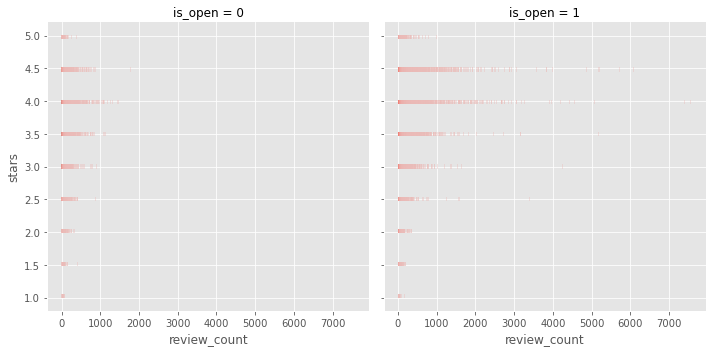

<Figure size 576x576 with 0 Axes>

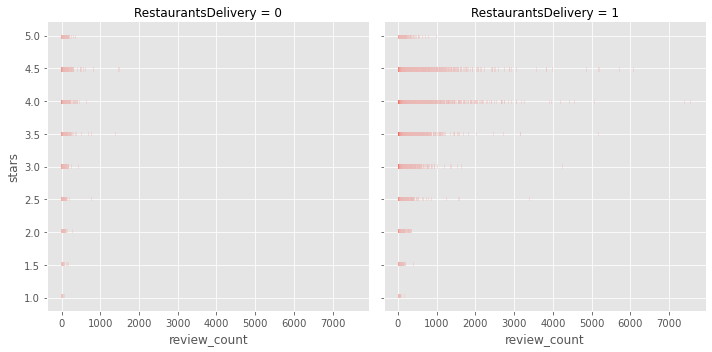

<Figure size 576x576 with 0 Axes>

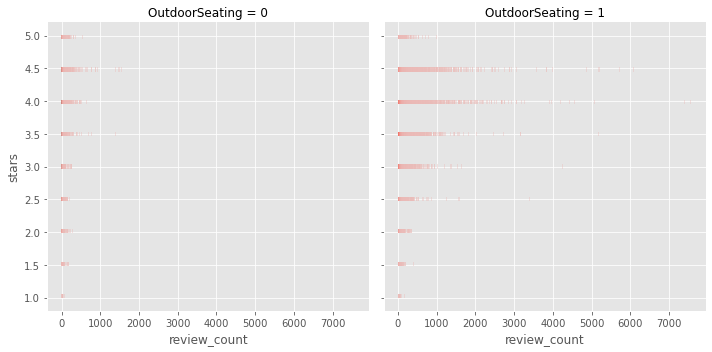

<Figure size 576x576 with 0 Axes>

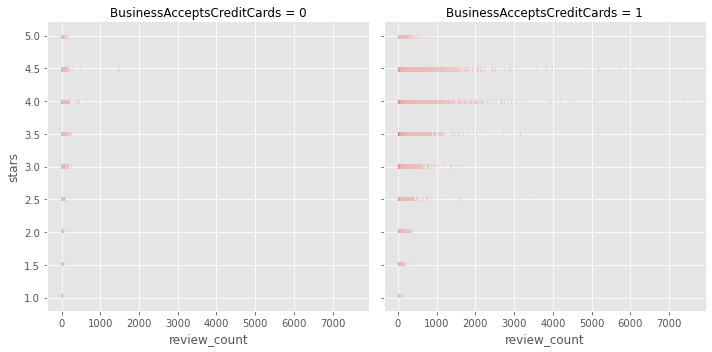

<Figure size 576x576 with 0 Axes>

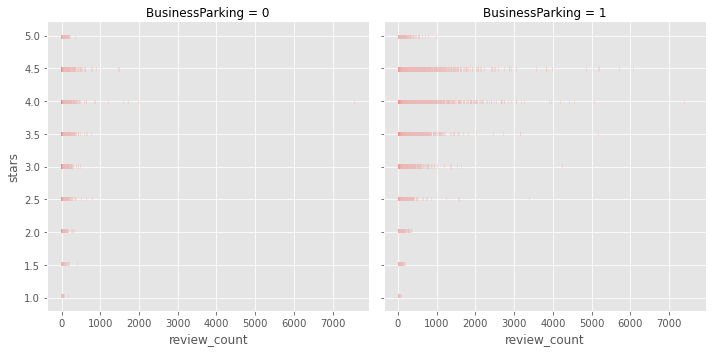

<Figure size 576x576 with 0 Axes>

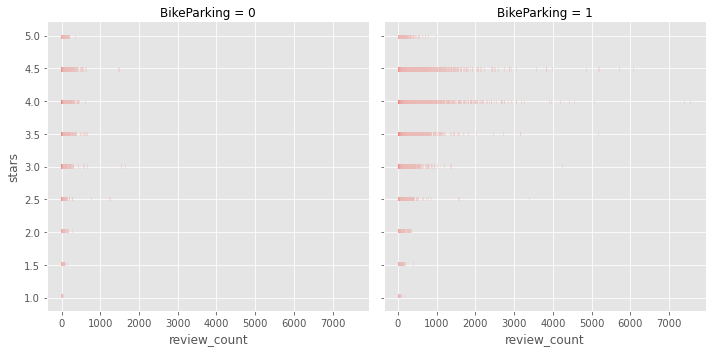

<Figure size 576x576 with 0 Axes>

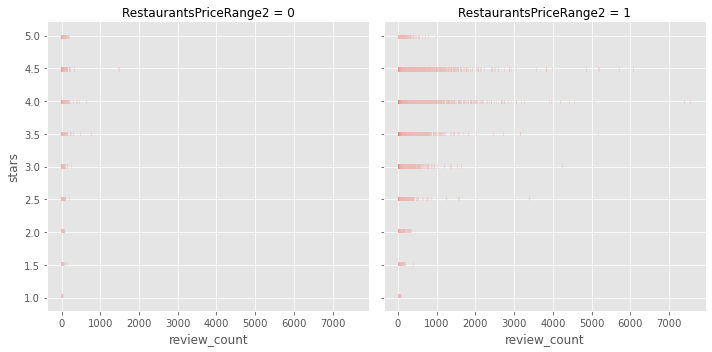

<Figure size 576x576 with 0 Axes>

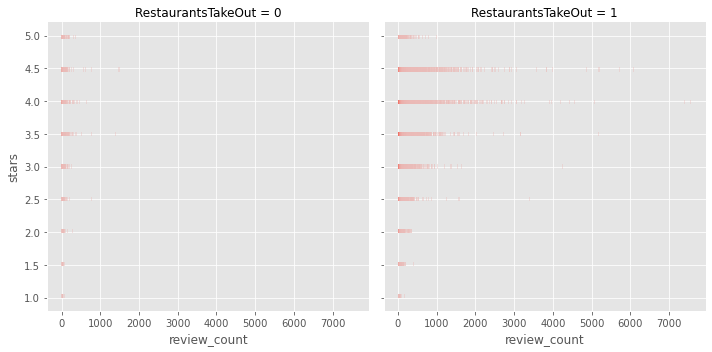

<Figure size 576x576 with 0 Axes>

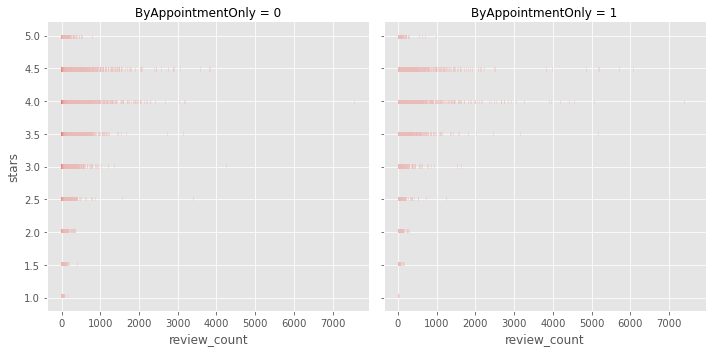

<Figure size 576x576 with 0 Axes>

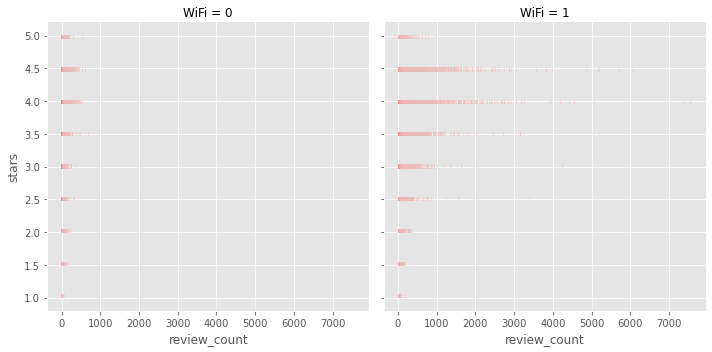

<Figure size 576x576 with 0 Axes>

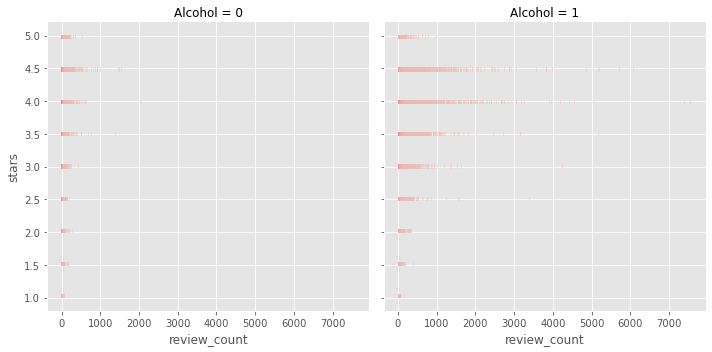

<Figure size 576x576 with 0 Axes>

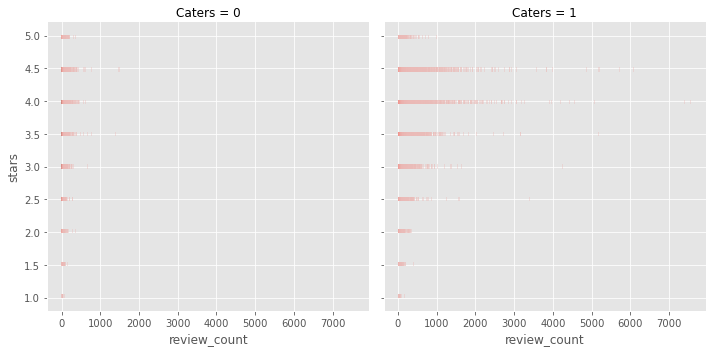

<Figure size 576x576 with 0 Axes>

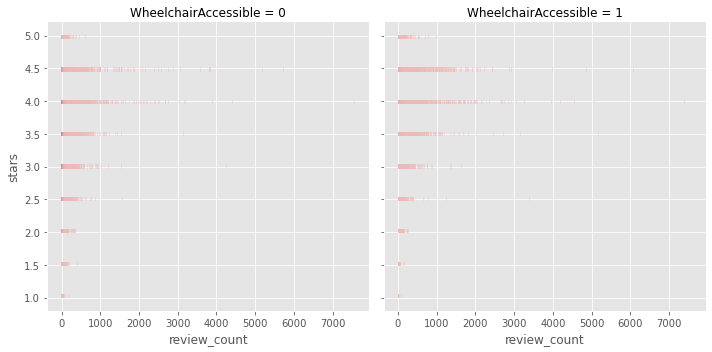

<Figure size 576x576 with 0 Axes>

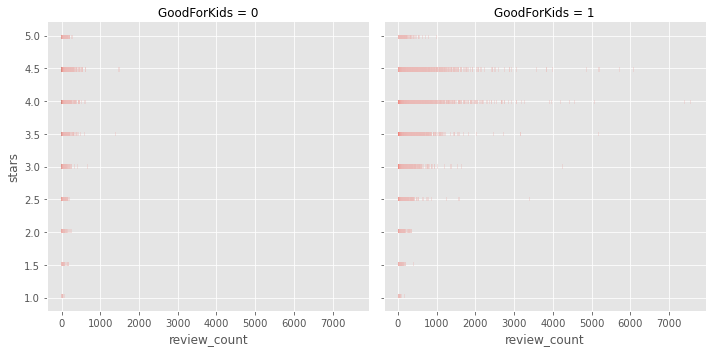

<Figure size 576x576 with 0 Axes>

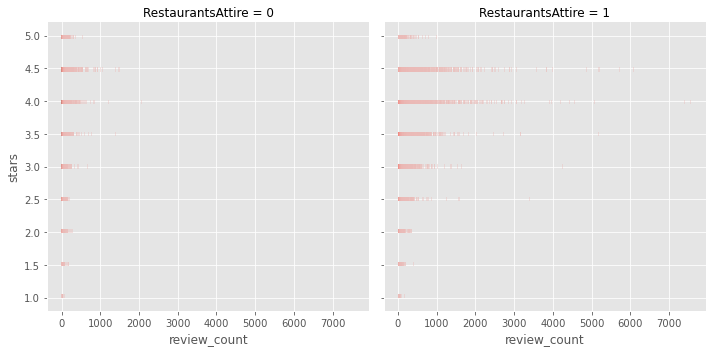

<Figure size 576x576 with 0 Axes>

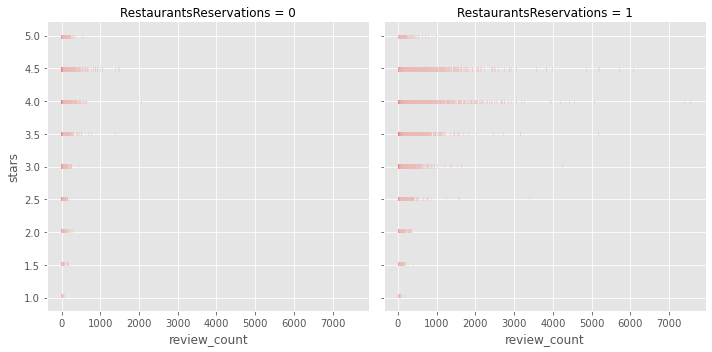

<Figure size 576x576 with 0 Axes>

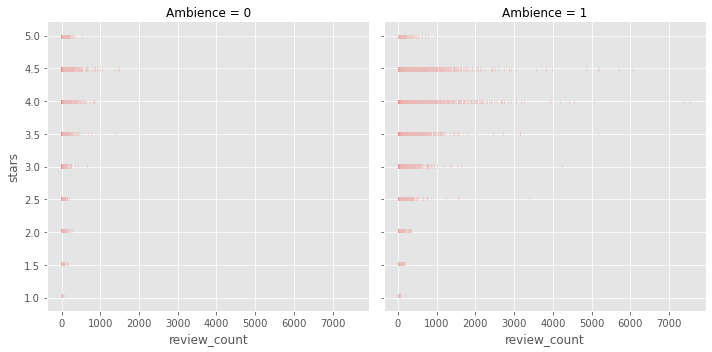

<Figure size 576x576 with 0 Axes>

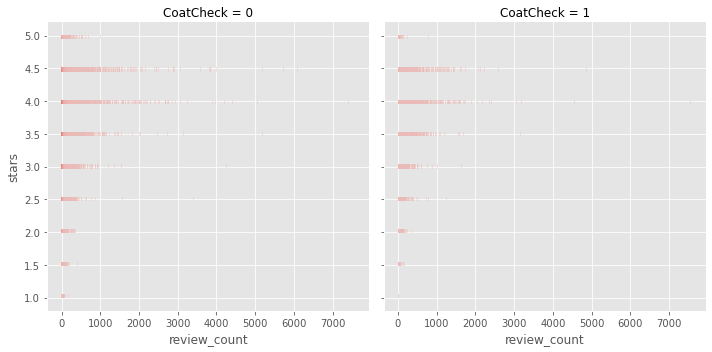

<Figure size 576x576 with 0 Axes>

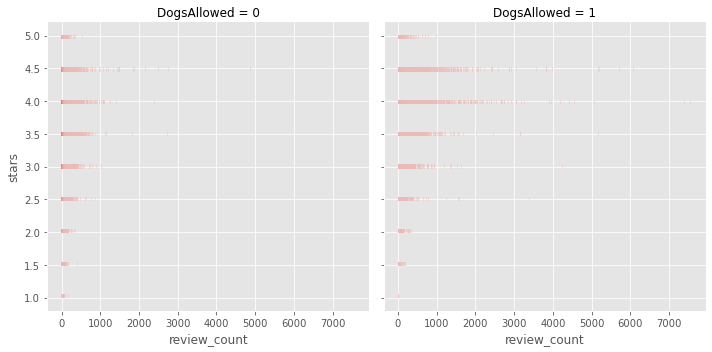

<Figure size 576x576 with 0 Axes>

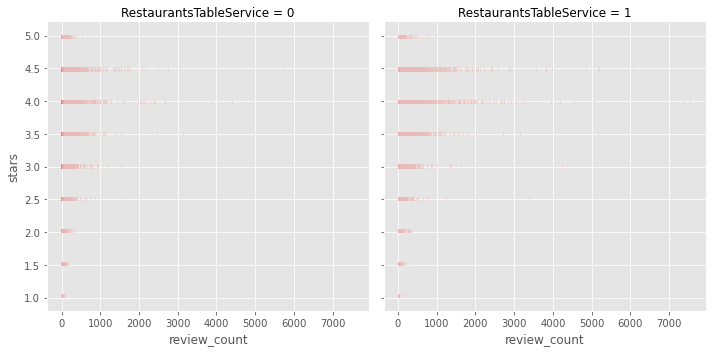

<Figure size 576x576 with 0 Axes>

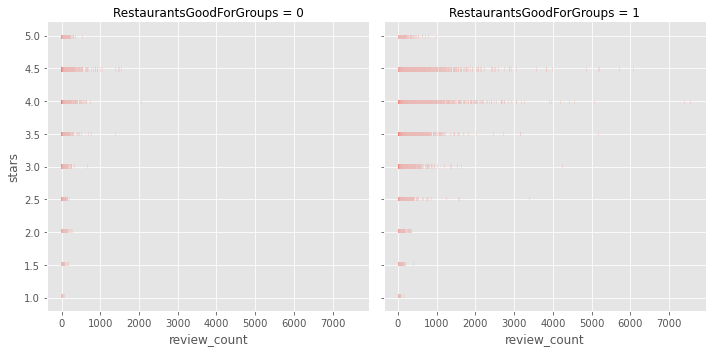

<Figure size 576x576 with 0 Axes>

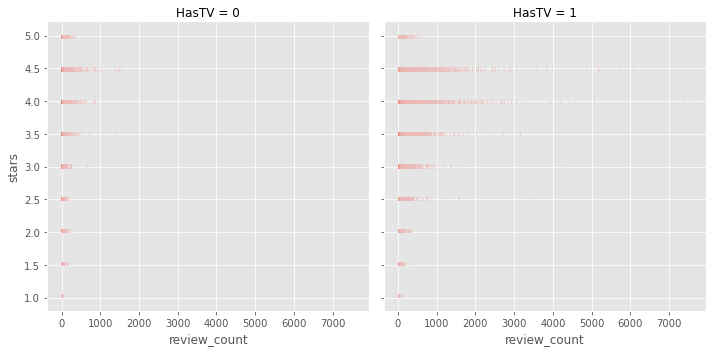

<Figure size 576x576 with 0 Axes>

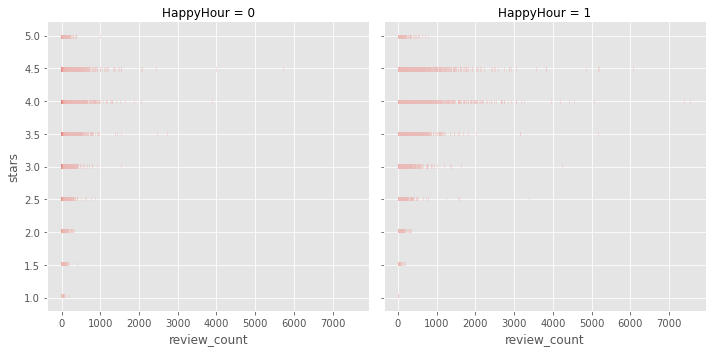

<Figure size 576x576 with 0 Axes>

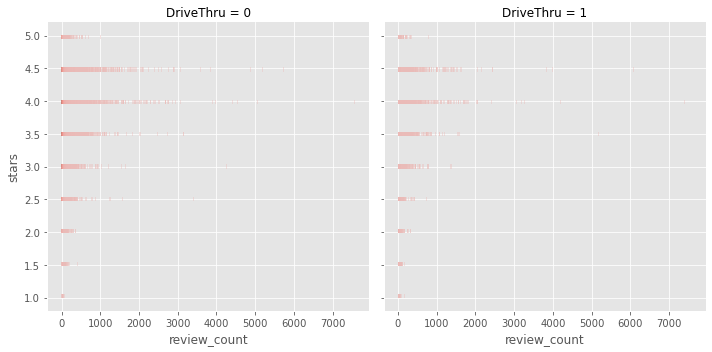

<Figure size 576x576 with 0 Axes>

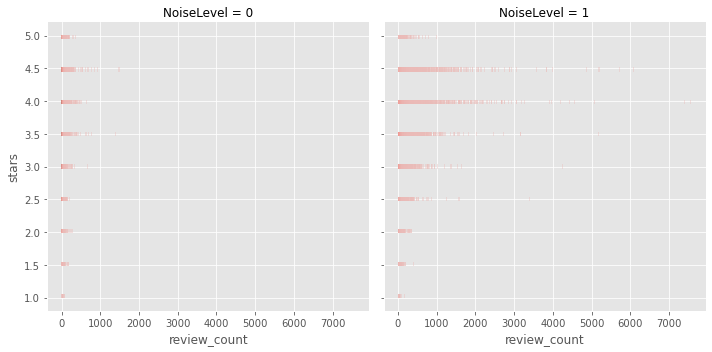

<Figure size 576x576 with 0 Axes>

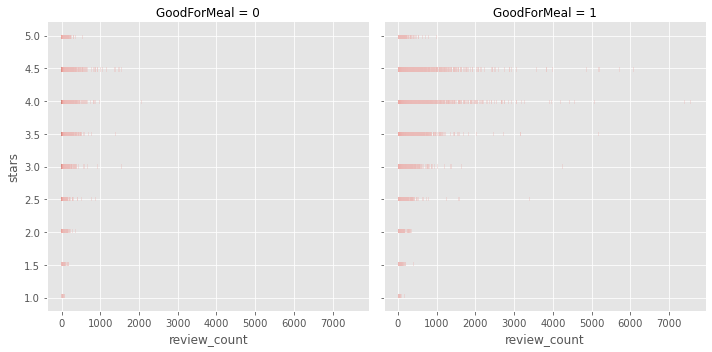

<Figure size 576x576 with 0 Axes>

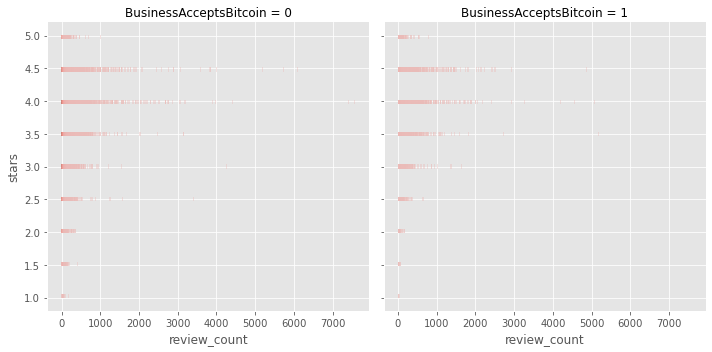

<Figure size 576x576 with 0 Axes>

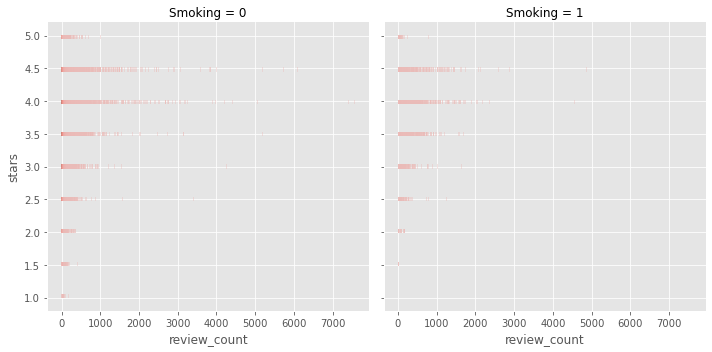

<Figure size 576x576 with 0 Axes>

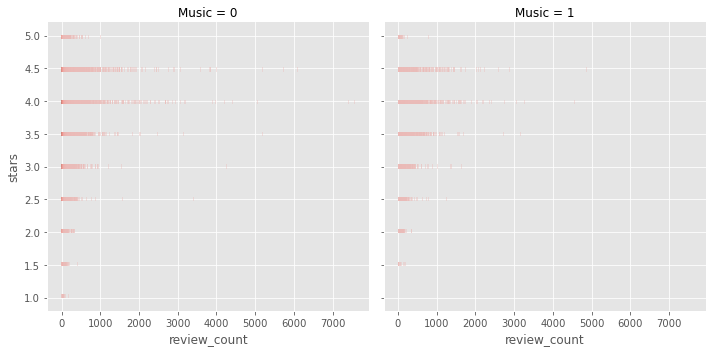

<Figure size 576x576 with 0 Axes>

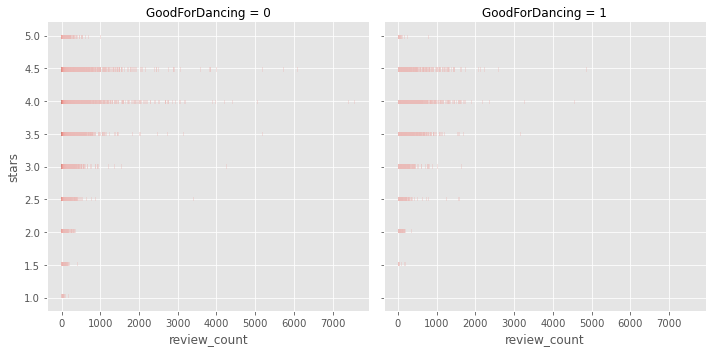

<Figure size 576x576 with 0 Axes>

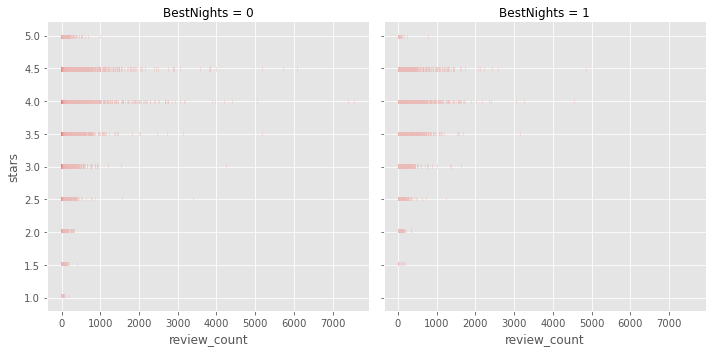

<Figure size 576x576 with 0 Axes>

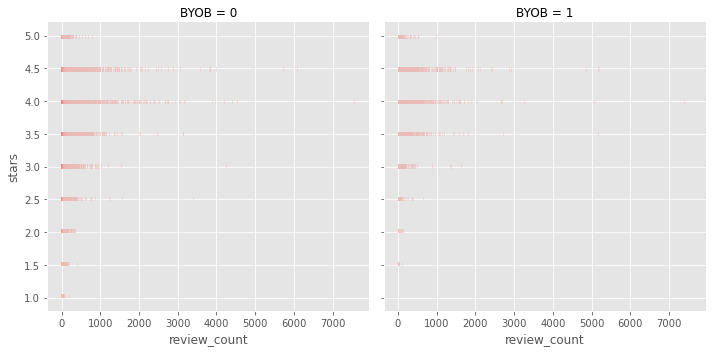

<Figure size 576x576 with 0 Axes>

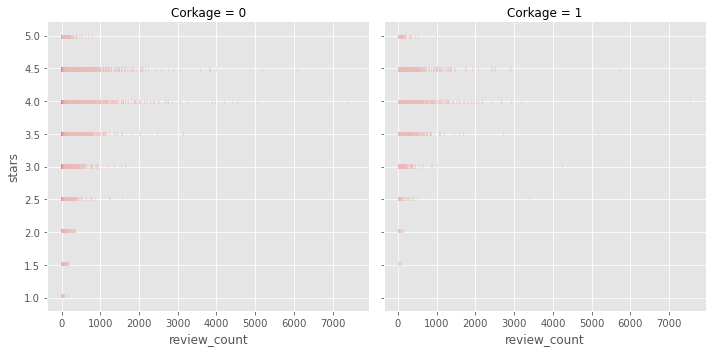

<Figure size 576x576 with 0 Axes>

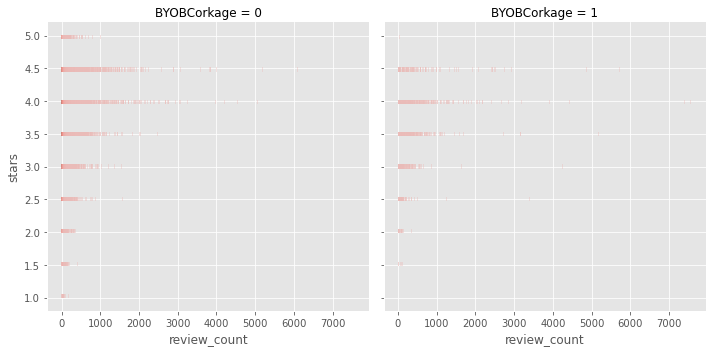

<Figure size 576x576 with 0 Axes>

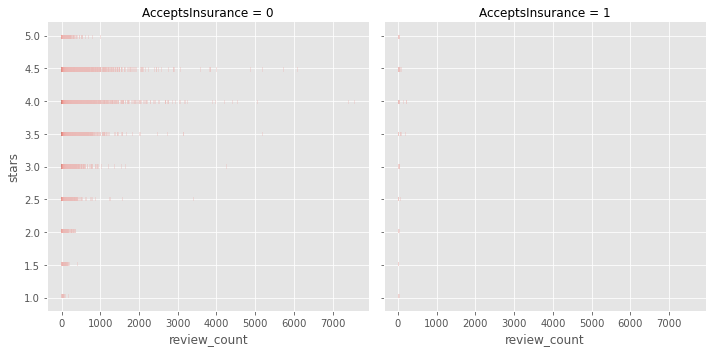

<Figure size 576x576 with 0 Axes>

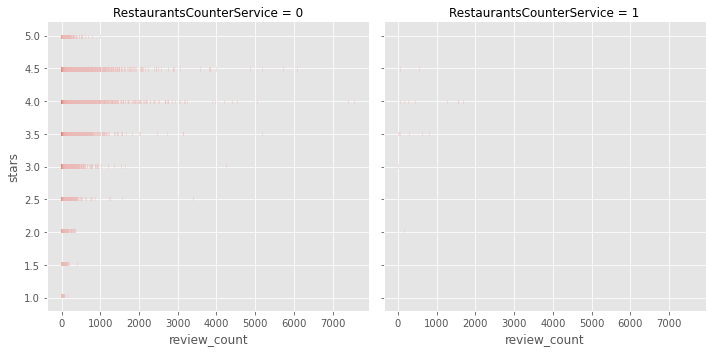

<Figure size 576x576 with 0 Axes>

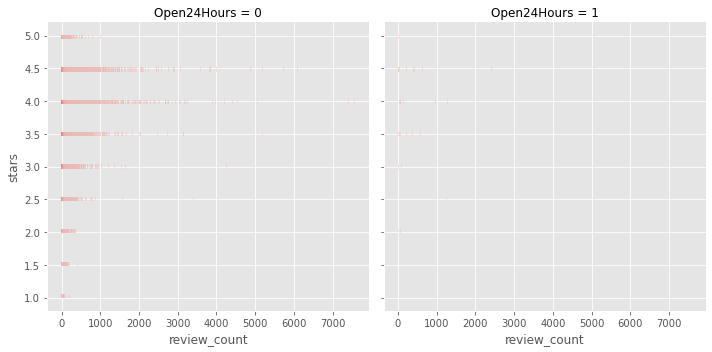

<Figure size 576x576 with 0 Axes>

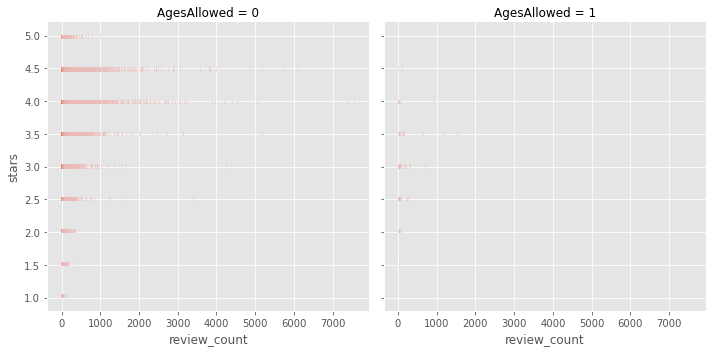

<Figure size 576x576 with 0 Axes>

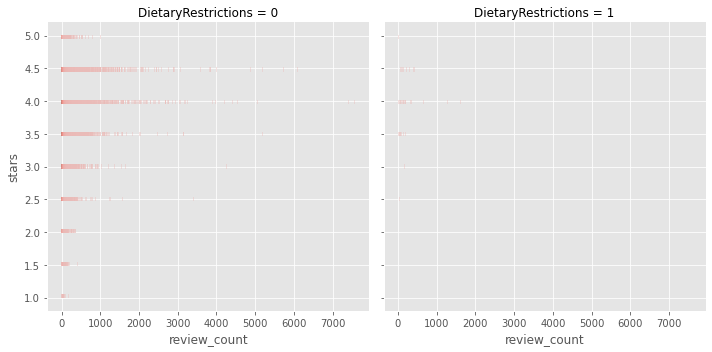

<Figure size 576x576 with 0 Axes>

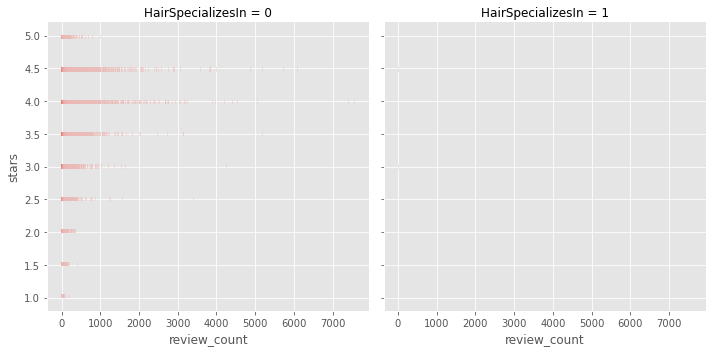

In [32]:
def plot(feature):
    plt.figure(figsize=(8, 8))
    sns.displot(data=business_df, y='stars', x='review_count', col=feature, alpha=.4)

bool_features = []
for tup in make_query("PRAGMA table_info(businesses)"):
    if tup[2]=='BOOLEAN':
        bool_features.append(tup[1])

for feature in bool_features:
    plot(feature)

In [33]:
'business_id', 'stars', 'review_id', 'user_id'

('business_id', 'stars', 'review_id', 'user_id')

In [34]:
make_query("PRAGMA table_info(reviews)")

[(0, 'review_id', 'VARCHAR', 0, None, 1),
 (1, 'user_id', 'INTEGER', 0, None, 0),
 (2, 'business_id', 'INTEGER', 0, None, 0),
 (3, 'stars', 'FLOAT', 0, None, 0),
 (4, 'useful', 'INTEGER', 0, None, 0),
 (5, 'funny', 'INTEGER', 0, None, 0),
 (6, 'cool', 'INTEGER', 0, None, 0),
 (7, 'text', 'VARCHAR', 0, None, 0),
 (8, 'date', 'TIMESTAMP', 0, None, 0)]

In [35]:
#Getting dataframe from table
review_df_cols = list(zip(*make_query("PRAGMA table_info(reviews)")))[1]
review_df = make_frame(query='SELECT business_id,stars,review_id,user_id   FROM reviews', legend=['business_id', 'stars', 'review_id', 'user_id'])
review_df.head()

,business_id,stars,review_id,user_id
0,799,3.0,KU_O5udG6zpxOg-VcAEodg,124234
1,5659,3.0,saUsX_uimxRlCVr67Z4Jig,98159
2,2729,5.0,AqPFMleE6RsU23_auESxiA,164430
3,2626,4.0,Sx8TMOWLNuJBWer-0pcmoA,150111
4,1186,1.0,JrIxlS1TzJ-iCu79ul40cQ,132438


In [36]:
make_query("PRAGMA table_info(users)")

[(0, 'user_id', 'INTEGER', 1, None, 1),
 (1, 'name', 'VARCHAR', 0, None, 0),
 (2, 'review_count', 'INTEGER', 0, None, 0),
 (3, 'yelping_since', 'TIMESTAMP', 0, None, 0),
 (4, 'useful', 'INTEGER', 0, None, 0),
 (5, 'funny', 'INTEGER', 0, None, 0),
 (6, 'cool', 'INTEGER', 0, None, 0),
 (7, 'elite', 'VARCHAR', 0, None, 0),
 (8, 'friends', 'VARCHAR', 0, None, 0),
 (9, 'fans', 'INTEGER', 0, None, 0),
 (10, 'average_stars', 'FLOAT', 0, None, 0),
 (11, 'compliment_hot', 'INTEGER', 0, None, 0),
 (12, 'compliment_more', 'INTEGER', 0, None, 0),
 (13, 'compliment_profile', 'INTEGER', 0, None, 0),
 (14, 'compliment_cute', 'INTEGER', 0, None, 0),
 (15, 'compliment_list', 'INTEGER', 0, None, 0),
 (16, 'compliment_note', 'INTEGER', 0, None, 0),
 (17, 'compliment_plain', 'INTEGER', 0, None, 0),
 (18, 'compliment_cool', 'INTEGER', 0, None, 0),
 (19, 'compliment_funny', 'INTEGER', 0, None, 0),
 (20, 'compliment_writer', 'INTEGER', 0, None, 0),
 (21, 'compliment_photos', 'INTEGER', 0, None, 0)]

In [37]:
user_df_cols = list(zip(*make_query("PRAGMA table_info(users)")))[1]
user_df = make_frame(query='SELECT user_id,name  FROM users WHERE review_count>10 ORDER BY review_count desc limit 10000 ', legend=['user_id','user_name'])
user_df.head()

,user_id,user_name
0,17169,Fox
1,795339,Victor
2,4723,Bruce
3,606393,Shila
4,152,Kim


In [38]:
user_df.shape

(10000, 2)

In [39]:


# Combine the columns from the given dataframe to consist only of required columns for model
ratings_data = review_df.join(business_df.set_index('business_id'), on='business_id',  how='left', lsuffix='_review', rsuffix='_business')
ratings_data = ratings_data.join(user_df.set_index('user_id'), on = 'user_id', how='left', lsuffix='_left', rsuffix='_right')
ratings_data.head()



,business_id,stars_review,review_id,user_id,Restaurant_name,stars_business,review_count,is_open,categories,RestaurantsDelivery,...,BYOB,Corkage,BYOBCorkage,AcceptsInsurance,RestaurantsCounterService,Open24Hours,AgesAllowed,DietaryRestrictions,HairSpecializesIn,user_name
0,799,3.0,KU_O5udG6zpxOg-VcAEodg,124234,Turning Point of North Wales,3.0,169,1,"Restaurants, Breakfast & Brunch, Food, Juice B...",1,...,0,0,0,0,0,0,0,0,0,NaN
1,5659,3.0,saUsX_uimxRlCVr67Z4Jig,98159,Kettle Restaurant,3.5,47,1,"Restaurants, Breakfast & Brunch",1,...,0,0,0,0,0,0,0,0,0,Debra
2,2729,5.0,AqPFMleE6RsU23_auESxiA,164430,Zaika,4.0,181,1,"Halal, Pakistani, Restaurants, Indian",1,...,0,0,0,0,0,0,0,0,0,NaN
3,2626,4.0,Sx8TMOWLNuJBWer-0pcmoA,150111,Melt,4.0,32,0,"Sandwiches, Beer, Wine & Spirits, Bars, Food, ...",1,...,0,0,0,0,0,0,0,0,0,NaN
4,1186,1.0,JrIxlS1TzJ-iCu79ul40cQ,132438,Dmitri's,4.0,273,0,"Mediterranean, Restaurants, Seafood, Greek",1,...,0,0,1,0,0,0,0,0,0,NaN


In [40]:
ratings_data.shape

(5126276, 49)

In [41]:
ratings_data_sample = ratings_data.head(1000)

In [42]:
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, business id and stars (in that order).
data = Dataset.load_from_df(ratings_data_sample[['user_id', 'business_id', 'stars_review']], reader)

# An antiset is a set of those user and item pairs for which a rating doesn't exist in original dataset
# We will use this data for testing
anti_set = data.build_full_trainset().build_anti_testset()
#trainset, testset = train_test_split(data, test_size=0.25)

In [43]:


sim_options = { 'name': 'cosine' ,'user_based':  False}
kf = KFold(n_splits=5)
algo = KNNWithMeans(k =3 , sim_options = sim_options)
best_algo = None
best_rmse = 1000.0
best_pred = None
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    rmse = accuracy.rmse(predictions, verbose=True)
    if rmse < best_rmse:
        best_rmse= rmse
        best_algo = algo
        best_pred = predictions



Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2430
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3709
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.2383
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3857
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.3801


In [44]:
pred_df = pd.DataFrame(best_pred).merge(ratings_data_sample , left_on = ['uid', 'iid'], right_on = ['user_id', 'business_id'])
pred_df[['uid', 'iid',  'user_name', 'user_id', 'Restaurant_name', 'business_id', 'est','stars_review']]

,uid,iid,user_name,user_id,Restaurant_name,business_id,est,stars_review
0,116138,914,NaN,116138,La Tavola Ristorante Italiano,914,3.84,5.0
1,171258,3870,NaN,171258,Joe Bob's Chicken Palace,3870,3.84,2.0
2,71392,4550,NaN,71392,1200 Chophouse,4550,3.84,5.0
3,129983,4416,NaN,129983,El Camino Real,4416,3.84,3.0
4,60448,4016,NaN,60448,R2L,4016,3.84,4.0
...,...,...,...,...,...,...,...,...
195,38278,1541,NaN,38278,Terrace Lounge,1541,3.84,2.0
196,41498,5852,NaN,41498,More Than Just Ice Cream,5852,3.84,3.0
197,100875,5272,NaN,100875,Blues City Deli,5272,3.84,5.0
198,145543,5683,NaN,145543,Larry's Steaks,5683,3.84,5.0


In [45]:
anti_pre = best_algo.test(anti_set)
pred_df = pd.DataFrame(anti_pre).merge(business_df , left_on = ['iid'], right_on = ['business_id'])
pred_df = pd.DataFrame(pred_df).merge(user_df , left_on = ['uid'], right_on = ['user_id'])

In [46]:
pred_df[:1000]

,uid,iid,r_ui,est,details,business_id,Restaurant_name,stars,review_count,is_open,...,Corkage,BYOBCorkage,AcceptsInsurance,RestaurantsCounterService,Open24Hours,AgesAllowed,DietaryRestrictions,HairSpecializesIn,user_id,user_name
0,42869,5659,3.854,3.00000,"{'actual_k': 0, 'was_impossible': False}",5659,Kettle Restaurant,3.5,47,1,...,0,0,0,0,0,0,0,0,42869,Heidi
1,42869,2729,3.854,3.50000,"{'actual_k': 0, 'was_impossible': False}",2729,Zaika,4.0,181,1,...,0,0,0,0,0,0,0,0,42869,Heidi
2,42869,2626,3.854,4.00000,"{'actual_k': 0, 'was_impossible': False}",2626,Melt,4.0,32,0,...,0,0,0,0,0,0,0,0,42869,Heidi
3,42869,1186,3.854,1.00000,"{'actual_k': 0, 'was_impossible': False}",1186,Dmitri's,4.0,273,0,...,0,1,0,0,0,0,0,0,42869,Heidi
4,42869,1370,3.854,3.00000,"{'actual_k': 0, 'was_impossible': False}",1370,Fries Rebellion,3.5,103,0,...,0,0,0,0,0,0,0,0,42869,Heidi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5282,1367,3.854,3.85625,"{'was_impossible': True, 'reason': 'User and/o...",1367,LA Smokehouse,4.0,79,0,...,0,0,0,0,0,0,0,0,5282,Cassie
996,5282,4797,3.854,3.85625,"{'was_impossible': True, 'reason': 'User and/o...",4797,Iris,4.0,67,0,...,0,0,0,0,0,0,0,0,5282,Cassie
997,5282,1574,3.854,3.85625,"{'was_impossible': True, 'reason': 'User and/o...",1574,Sen Thai Asian Bistro,4.0,181,1,...,0,0,0,0,0,0,0,0,5282,Cassie
998,5282,4933,3.854,3.85625,"{'was_impossible': True, 'reason': 'User and/o...",4933,Petra Restaurant,4.0,160,1,...,0,0,0,0,0,0,0,0,5282,Cassie


In [47]:

## Recommend a restaurant to the user if the estimated rating is equal to 5

pred_df[(pred_df['est'] == 5)&(pred_df['user_id']=='7725')]

,uid,iid,r_ui,est,details,business_id,Restaurant_name,stars,review_count,is_open,...,Corkage,BYOBCorkage,AcceptsInsurance,RestaurantsCounterService,Open24Hours,AgesAllowed,DietaryRestrictions,HairSpecializesIn,user_id,user_name


In [48]:
def get_recommendations(user_id, estimated_prediction):
    df_recommended = pred_df[(pred_df['est'] >= estimated_prediction) & (pred_df['user_id'] == user_id)]
    restaurants = df_recommended['Restaurant_name']
    return restaurants

In [49]:


user = '7725'
recommendations = get_recommendations(user, 5)

print('\n\nRecommendations are listed below for userid ', user)
print('\n Top 10 Recommended Restaurants')
print(recommendations[:10])





Recommendations are listed below for userid  7725

 Top 10 Recommended Restaurants
Series([], Name: Restaurant_name, dtype: object)
